<a id="title_ID"></a>
# Beginner: Read and Display a TESS Full Frame Image

This notebook tutorial demonstrates how to load and display a TESS full frame image (FFI).  We will display the image with the world coordinate system (WCS) overlayed on top.

***

## Import Statements
* **astropy.io.fits** allows us to interact with the FITS files.
* **astropy.wcs.WCS** allows us to interpret the world coordinate system.
* **matplotlib.pyplot** is used to display the image.
* **numpy** is used for array manipulation.

In [1]:
%matplotlib inline
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os
import lightkurve as lk

## Introduction

TESS periodically reads out the entire frame of all four cameras, nominally every 30 minutes, and stores them as full frame images.  Each camera covers ~24x24 degrees on the sky.  These images can be used to construct light curves at 30-minute cadence for any object within the camera's field of view, in contrast to the subset of targets chosen by the mission to be read-out at shorter cadence (nominally two minutes) that receive mission-produced light curves.

This tutorial will refer to a couple TESS-related terms that we define here.
* Sector = TESS observes the sky in regions of 24x96 degrees for approximately 1 month at a time.  Each of these regions is referred to as a "sector", starting with Sector 1.
* HDU = Header Data Unit.  A FITS file is made up of HDUs that contain data and metadata relating to the file. The first HDU is called the primary HDU, and anything that follows is considered an "extension", e.g., "the first FITS extension", "the second FITS extension", etc.
* BJD = Barycentric Julian Date, the Julian Date that has been corrected for differences in the Earth's position with respect to the Solar System center of mass.
* BTJD =  Barycentric TESS Julian Date, the timestamp measured in BJD, but offset by 2457000.0.  I.e., BTJD = BJD - 2457000.0
* WCS = World Coordinate System, A FITS convention used to store coordinate information inside FITS headers.  For TESS full frame images, it is used to provide the translation needed to go from pixel coorindates to celestial coordinates in right ascension and declination.

## Obtaining The Full Frame Image

We will read the full frame image from Sector 1 using the MAST URL location.  So that we can get started with understanding the file contents without reviewing how to automatically search for and retrieve TESS files, we won't show how to search and retrieve TESS FFIs in this tutorial.  Consult other TESS tutorials [in the TESS Archive Handbook](https://outerspace.stsci.edu/display/TESS/6.0+-+Data+Search+Tutorials) for much more information on how to search for TESS data using MAST services.

In [2]:
datafile = '/s4/tess2018292095940-s0004-4-1-0124-s_ffic.fits'
fits_file = datadir + datafile

## Understanding The FFI FITS File Structure

TESS FFI FITS files contain a primary HDU with metadata stored in the header.  The first extension HDU contains more metadata in the header, and stores the full frame image.  The second extension HDU contains the uncertainty values for the image.  Let's examine the structure of the FITS file using the astropy.fits `info` function, which shows the FITS file format in more detail.


In [132]:
fits.info(fits_file)

ValueError: Empty filename: []

## Reading the WCS and Calibrated Image

Now that we have the file, let's store the world coordinate system information for use later.  We can use the astropy.wcs `WCS` function to store the information from the image extension HDU's header.

The following command opens the file, extracts the WCS and Image data and then closes the file. Note this file is quite large and may take a few moments to dowload.

In [4]:
with fits.open(fits_file, mode = "readonly") as hdulist:
    wcs_info = WCS(hdulist[1].header)
    cal_image = hdulist[1].data
    header = hdulist[1].header

In [5]:
# Use the header to determine the mid-point of the exposure time for this FFI.
mid_time = (header['TSTOP'] + header['TSTART']) / 2

## Display the Image
We show the 2048x2048 image, adjusting the scale so that we can see more of the stars.
We also imprint the WCS on top of the image.

(2078, 2136)

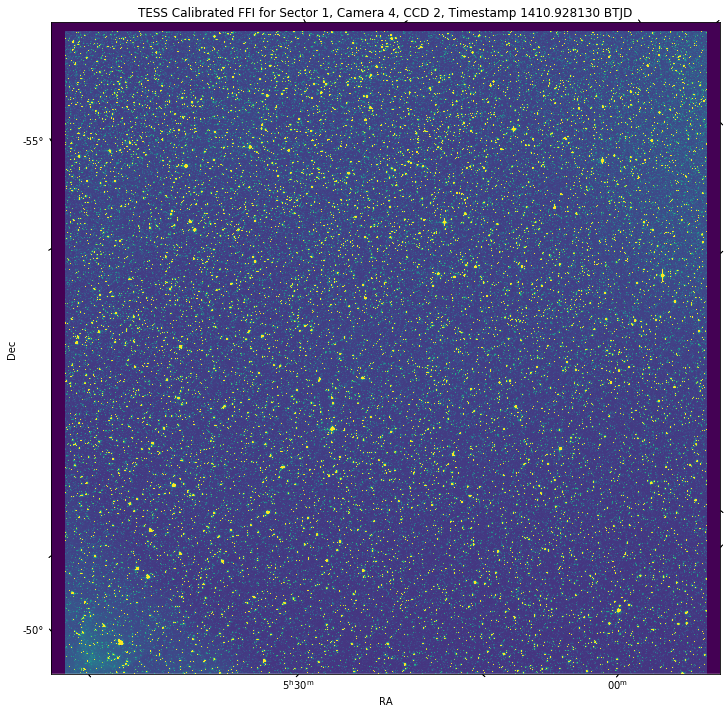

In [15]:
plt.figure(figsize = (12,12))

plt.subplot(111, projection = wcs_info)
plt.imshow(cal_image, vmin = np.percentile(cal_image,4),vmax = np.percentile(cal_image, 98),origin = "lower")
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title("TESS Calibrated FFI for Sector 1, Camera 4, CCD 2, Timestamp %f BTJD" % mid_time)

#plt.scatter(col, row, c='w')
#
#plt.annotate('beta Pictoris', xy=(col, row), xytext=(3, 1.5),
#            arrowprops=dict(facecolor='black', shrink=0.005))
#
#plt.xlim(0, 300)
#plt.ylim(0, 300)

cal_image.shape

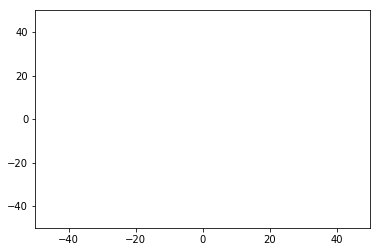

In [9]:
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=60, metadata=metadata)

fig = plt.figure()
l, = plt.plot([], [], 'k-o')

plt.xlim(-50, 50)
plt.ylim(-50, 50)

x0, y0 = 1, 1

with writer.saving(fig, "writer_test.mp4", 100):
    for i in range(1000):
        x0 += 5 * np.random.randn()
        y0 += 5 * np.random.randn()
        l.set_data(x0, y0)
        writer.grab_frame()

## A Few Image Details
We describe some of the details you see on this FFI. For more detailed information please see the TESS Instrument Handbook (Section 4.1).  Notice that our image is (2078, 2136) in size. Calibration row and columns are read-out in addition to the image data. These rows and columns remain in the calibrated image.

### Leading and Trailing Black
There are 4 sets of 11 columns (44 columns in total) that make up the leading and trailing black.  Each CCD is read in 4 slices and each slice has an 11 column leading black and an 11 column trailing black. All of the leading black are placed in the first 44 columns while the trailing black are the last 44 columns.

### Virtual, Smear and Buffer
The top 30 rows are, from the top, 10 virtual rows, 10 smear rows and 10 buffer rows.

### Bright Area on Left
Data annomalies are discussed in the TESS Setor 1 Data Release Notes. This bright area may be caused by some scattered light.

In [2]:
tpf = lk.search_targetpixelfile('beta Pictoris', sector=6).download()
#tpf.show_properties()
c, r = tpf.estimate_centroids()
col = np.nanmedian(c)
row = np.nanmedian(r)

In [47]:
tc = lk.search_tesscut('beta Pictoris', sector=6).download()

In [22]:
tpf.ccd

3

In [5]:
col

1661.7014340276476

In [6]:
row

619.4639396240314

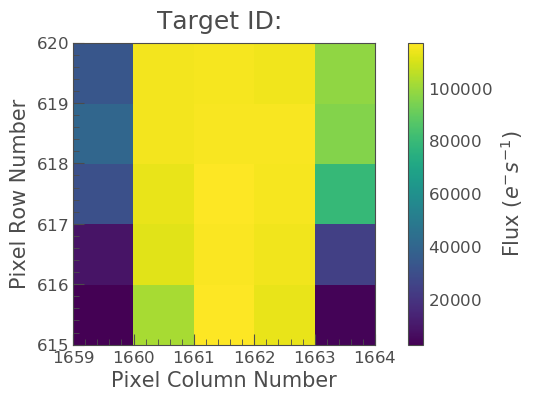

In [55]:
tc.plot();

# Make a movie

In [14]:
fnames = np.sort(glob('s6/*.fits'))

In [15]:
fnames

array(['s6/tess2018349182939-s0006-3-3-0126-s_ffic.fits',
       's6/tess2018349185939-s0006-3-3-0126-s_ffic.fits',
       's6/tess2018349192939-s0006-3-3-0126-s_ffic.fits',
       's6/tess2018349195939-s0006-3-3-0126-s_ffic.fits',
       's6/tess2018349202939-s0006-3-3-0126-s_ffic.fits',
       's6/tess2018349205939-s0006-3-3-0126-s_ffic.fits',
       's6/tess2018349212939-s0006-3-3-0126-s_ffic.fits',
       's6/tess2018349215939-s0006-3-3-0126-s_ffic.fits',
       's6/tess2018349222939-s0006-3-3-0126-s_ffic.fits',
       's6/tess2018349225939-s0006-3-3-0126-s_ffic.fits',
       's6/tess2018349232939-s0006-3-3-0126-s_ffic.fits',
       's6/tess2018349235939-s0006-3-3-0126-s_ffic.fits',
       's6/tess2018350002939-s0006-3-3-0126-s_ffic.fits',
       's6/tess2018350005939-s0006-3-3-0126-s_ffic.fits',
       's6/tess2018350012939-s0006-3-3-0126-s_ffic.fits',
       's6/tess2018350015939-s0006-3-3-0126-s_ffic.fits',
       's6/tess2018350022939-s0006-3-3-0126-s_ffic.fits',
       's6/tes

In [16]:
datadir = os.getcwd()
fits_file = [datadir + '/' + i for i in fnames]

In [17]:
datadir

'/home/sebastian/Downloads/TESSbulkdownloads/FFIs'

In [18]:
fits_file[0]

'/home/sebastian/Downloads/TESSbulkdownloads/FFIs/s6/tess2018349182939-s0006-3-3-0126-s_ffic.fits'

In [19]:
len(fits_file)

993

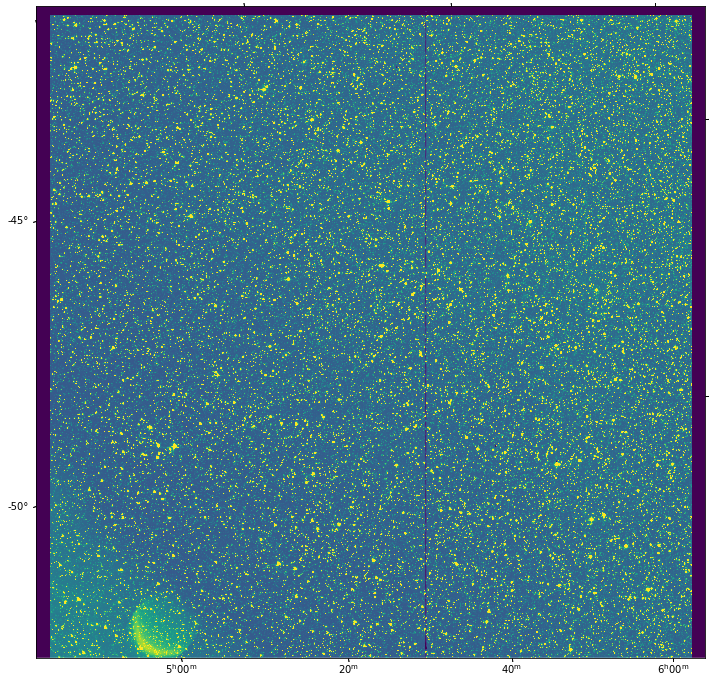

In [104]:
%matplotlib inline
with fits.open(fits_file[-1], mode = "readonly") as hdulist:
    wcs_info = WCS(hdulist[1].header)
    cal_image = hdulist[1].data
    header = hdulist[1].header
    
#mid_time = (header['TSTOP'] + header['TSTART']) / 2

plt.figure(figsize = (12,12))

plt.subplot(111, projection = wcs_info)
plt.imshow(cal_image, vmin = np.percentile(cal_image,1),vmax = np.percentile(cal_image, 96),origin = "lower")
#plt.xlabel('RA')
#plt.ylabel('Dec')
#plt.title("TESS Calibrated FFI for Sector 1, Camera 4, CCD 2, Timestamp %f BTJD" % mid_time)

#plt.scatter(col, row, c='w')
#
#plt.annotate('beta Pictoris', xy=(col, row), xytext=(3, 1.5),
#            arrowprops=dict(facecolor='black', shrink=0.005))
#
#plt.ylim(row-30, row+30)
#plt.xlim(col-30, col+30)

#cal_image.shape
plt.show()

In [5]:
sec = 4

fnames = np.sort(glob('s{0}/*.fits'.format(sec)))
datadir = os.getcwd()
fits_file = [datadir + '/' + i for i in fnames]

tpf = lk.search_targetpixelfile('beta Pictoris', sector=sec).download()
#tpf.show_properties()
c, r = tpf.estimate_centroids()
col = np.nanmedian(c)
row = np.nanmedian(r)

#https://matplotlib.org/examples/animation/moviewriter.html

nr_frames = len(fits_file)

wcs_info = []
cal_image = []
header = []

for i in log_progress(range(0, nr_frames)):
    hdulist = fits.open(fits_file[i])#, mode = "readonly", memmap=False
    wcs_info.append(WCS(hdulist[1].header))
    cal_image.append(hdulist[1].data)
    header.append(hdulist[1].header)
    hdulist.close()

mid_time = (np.array([i['TSTOP'] for i in header]) + np.array([i['TSTART'] for i in header])) / 2

import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=30, metadata=metadata)

fig = plt.figure(figsize = (12,12))
#l, = plt.plot([], [], 'k-o')


with writer.saving(fig, "sector{0}_full.mp4".format(sec), 300):
    
    for j in log_progress(range(0, nr_frames)):

        plt.subplot(111, projection = wcs_info[j])
        plt.imshow(cal_image[j], vmin = np.percentile(cal_image[j],50),vmax = np.percentile(cal_image[j], 98),origin = "lower")
        
        #plt.ylim(row-30, row+30)
        #plt.xlim(col-30, col+30)
        
        plt.xlabel('RA')
        plt.ylabel('Dec')
        plt.title("TESS Calibrated FFI for Sector {0}, Camera {1}, CCD {2}, Timestamp {3:10.5f} BTJD".format(tpf.sector, tpf.camera, tpf.ccd, mid_time[j]))
        #print('Processed {0} out of {1}...'.format(j, nr_frames))
        #l.set_data(x0, y0)

        writer.grab_frame()

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )


In [12]:
#from copy import deep_copy
nr_frames = len(fits_file)

wcs_info = []
cal_image = []
header = []

for i in log_progress(range(0, nr_frames)):
    hdulist = fits.open(fits_file[i])#, mode = "readonly", memmap=False
    #data = deepcopy(hdulist[1].data)
    wcs_info.append(WCS(hdulist[1].header))
    cal_image.append(hdulist[1].data)
    header.append(hdulist[1].header)
    hdulist.close(verbose = True)

mid_time = (np.array([i['TSTOP'] for i in header]) + np.array([i['TSTART'] for i in header])) / 2